<a href="https://www.kaggle.com/code/erayyuztyurk/diabetes-project?scriptVersionId=167702403" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BUSINESS PROBLEM
------------------------------------------------------------------------------------------------------------------------
A machine learning model is requested to predict whether individuals have diabetes when their features are specified.
Before developing the model, it is expected that the necessary data analysis and feature engineering steps be performed.

# DATASET STORY
------------------------------------------------------------------------------------------------------------------------
The dataset is part of a large dataset maintained by the National Institute of Diabetes and Digestive and
Kidney Diseases in the United States. It consists of data used for diabetes research conducted on Pima Indian women
aged 21 and older living in Phoenix, the fifth-largest city in the state of Arizona, USA.

The target variable is defined as 'outcome,' where 1 indicates a positive diabetes test result, and 0 indicates
a negative result.

# FEATURES
------------------------------------------------------------------------------------------------------------------------
#### Variable Names
------------------------------------------------------------------------------------------------------------------------
- **Pregnancies:**               Number of pregnancies
- **Glucose:**                   2-hour plasma glucose concentration during an oral glucose tolerance test
- **Blood Pressure:**            Diastolic blood pressure (mm Hg)
- **Skin Thickness:**            Skinfold thickness (mm)
- **Insulin:**                   2-hour serum insulin (mu U/ml)
- **DiabetesPedigreeFunction:**  Diabetes pedigree function (2-hour plasma glucose concentration)
- **BMI:**                       Body mass index (weight in kg / (height in m)^2)
- **Age:**                       Age (years)
- **Outcome:**                   Presence (1) or absence (0) of diabetes
------------------------------------------------------------------------------------------------------------------------

# PROJECT TASKS

_The core focus of this project lies in feature engineering, where various techniques are applied to extract valuable insights from the dataset._

------------------------------------------------------------------------------------------------------------------------
#### Step 1: Exploratory Data Analysis
- 1.1 - Examining the big picture.
- 1.2 - Identifying numerical and categorical variables.
- 1.3 - Analyzing numerical and categorical variables.
- 1.4 - Conducting a target variable analysis.
- 1.5 - Performing outlier analysis.
- 1.6 - Performing missing data analysis.
- 1.7 - Performing correlation analysis.

#### Step 2: Feature Engineering
- 2.1 - Performing necessary operations for missing and outlier values.
- 2.2 - Creating new variables.
- 2.3 - Performing encoding operations.
- 2.4 - Standardizing numerical variables.

#### Step 3: Modelling
- 3.1 - K-Nearest Neighbors Model
- 3.2 - RandomForestClassifier Model

# Importing required libraries and setting options

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
import missingno as msno

pd.set_option("display.float_format", lambda x: f"{x:.4f}")
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows",50)

def show_rows(show=False):
    if show:
        pd.set_option("display.max_rows", None)
    else:
        pd.set_option("display.max_rows", 50)

# Reading Dataset

In [2]:
diabetes = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")
df = diabetes.copy()
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9000,0.1710,63,0
764,2,122,70,27,0,36.8000,0.3400,27,0
765,5,121,72,23,112,26.2000,0.2450,30,0
766,1,126,60,0,0,30.1000,0.3490,47,1


# Step 1: Exploratory Data Analysis
## 1.1 - Examine the big picture

In [3]:
def check_df(dataframe, show_value_counts = False):
    import pandas as pd
    pd.set_option("display.colheader_justify","left")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- SHAPE of Dataset -----------------------------------------------------------------------------------------------------------------------")
    print(dataframe.shape)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- DATA TYPES of Dataset ------------------------------------------------------------------------------------------------------------------")
    print(dataframe.dtypes)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- MEMORY USAGE of Dataset --------------------------------------------------------------------------------------------------------------  ")
    print(dataframe.memory_usage(deep=True) / (1024 * 1024), "\n (All are in MB)")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- MISSING VALUES in Dataset --------------------------------------------------------------------------------------------------------------")
    print(dataframe.isnull().sum())
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- DESCRIPTIVE Info about Dataset ---------------------------------------------------------------------------------------------------------")
    print(dataframe.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")

    if show_value_counts:
        print("-------- VALUE COUNTS in Dataset ----------------------------------------------------------------------------------------------------------------")
        for col in dataframe.columns:
            print(dataframe[col].value_counts())
            print("-------------------------------------------------------------------------------------------------------------------------------------------------")

In [4]:
#- an overview for dataframe
check_df(df, show_value_counts=False)
#---------------------------------------------------------------------------------------------
target_label = "Outcome"
#---------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------------
-------- SHAPE of Dataset -----------------------------------------------------------------------------------------------------------------------
(768, 9)
-------------------------------------------------------------------------------------------------------------------------------------------------
-------- DATA TYPES of Dataset ------------------------------------------------------------------------------------------------------------------
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
---------------------------------------------------------------------

#### Comments:
- Target Label is "Outcome" and values are 0 and 1.
- There is no NaN values.
- There are many min 0 values which do not make sense and should not be 0 in normal circumstances (e.g. Glucose, BloodPressure, SkinThickness, Insulin, BMI)
- There are skewed variables. But it can be deceptive as min value is 0 for above columns.
- Kurtosis is not examined by choice (if desired, it is required statsmodels or manual calculation).
- Accepted ranges for variables should be checked online for more info.

## 1.2 - Identify numerical and categorical variables.

In [5]:
def grab_column_names_based_on_types(dataframe, cardinal_threshold_percent=0.6, category_threshold_num=20):
    def is_date(string):
        from datetime import datetime as dt
        import pandas as pd
        try:
            if dt.strptime(string, '%Y-%m-%d %H:%M:%S'):
                return True
            else:
                return False
        except ValueError:
            return False
    date_cols = [col for col in dataframe.columns if (dataframe[col].dtype in ["O"] and all(is_date(str(value)) for value in dataframe.dropna(subset=[col])[col]) or type(dataframe[col].iloc[0]) is pd.Timestamp)]
    num_but_car_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int", "float"] and dataframe[col].nunique() == (dataframe.shape[0])]
    cat_but_car_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["O"] and dataframe[col].nunique() > (dataframe.shape[0] * cardinal_threshold_percent) and not col in date_cols]
    car_cols = num_but_car_cols + cat_but_car_cols
    num_but_cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int", "float"] and dataframe[col].nunique() < category_threshold_num]
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["O"] and not col in cat_but_car_cols and not col in date_cols] + num_but_cat_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int", "float"] and not col in num_but_cat_cols and not col in num_but_car_cols]

    print("------------------------------------------------------------------------------------------------------------")
    print(f"Observations Count: {dataframe.shape[0]}")
    print(f"Variables Count: {dataframe.shape[1]}")
    print("------------------------------------------------------------------------------------------------------------")
    print(f'Date Columns Count: {len(date_cols)} -> {date_cols}')
    print(f'Numeric Columns Count: {len(num_cols)} -> {num_cols}')
    print(f'Categorical Columns Count: {len(cat_cols)} -> {cat_cols}')
    print(f'Cardinal Columns Count: {len(car_cols)} -> {car_cols}')
    print("------------------------------------------------------------------------------------------------------------")
    print(f'Numeric but Cardinal Columns Count: {len(num_but_car_cols)} -> {num_but_car_cols}')
    print(f'Numeric but Categorical Columns Count: {len(num_but_cat_cols)} -> {num_but_cat_cols}')
    print(f'Categorical but Cardinal Columns Count: {len(num_but_cat_cols)} -> {cat_but_car_cols}')
    print("------------------------------------------------------------------------------------------------------------")
    if dataframe.shape[1] == (len(date_cols) + len(num_cols) + len(cat_cols) + len(car_cols)):
        print(f'Variables Count {dataframe.shape[1]} and Sum of Date,Numeric,Categorical and Cardinal Columns Counts {len(date_cols) + len(num_cols) + len(cat_cols) + len(car_cols)} are equal..')
    else:
        print(
            f'Variables Count {dataframe.shape[1]} and Sum of Date,Numeric,Categorical and Cardinal Columns Counts {len(date_cols) + len(num_cols) + len(cat_cols) + len(car_cols)} are NOT equal !!')
    print("------------------------------------------------------------------------------------------------------------")
    return num_cols, cat_cols, car_cols, date_cols

In [6]:
 #- determine column datatypes
num_cols, cat_cols, car_cols, date_cols = grab_column_names_based_on_types(diabetes)
#---------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------
Observations Count: 768
Variables Count: 9
------------------------------------------------------------------------------------------------------------
Date Columns Count: 0 -> []
Numeric Columns Count: 7 -> ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical Columns Count: 2 -> ['Pregnancies', 'Outcome']
Cardinal Columns Count: 0 -> []
------------------------------------------------------------------------------------------------------------
Numeric but Cardinal Columns Count: 0 -> []
Numeric but Categorical Columns Count: 2 -> ['Pregnancies', 'Outcome']
Categorical but Cardinal Columns Count: 2 -> []
------------------------------------------------------------------------------------------------------------
Variables Count 9 and Sum of Date,Numeric,Categorical and Cardinal Columns Counts 9 are equal..
----------------

#### Comments:
- There are 7 numerical and 2 categorical columns
- Pregnancies is accepted as categorical.
- Target Label is "Outcome" and values are 0 and 1.

## 1.3 - Analyze numerical and categorical variables.

In [7]:
def categoricals_summary(dataframe, column_name, plot=False):
    print(pd.DataFrame({column_name: dataframe[column_name].value_counts(),
                 "Ratio": 100 * (dataframe[column_name].value_counts() / len(dataframe))}))
    print("--------------------------------------------------------------------------------------------------------")

    if plot:
        sns.countplot(x=dataframe[column_name], data=dataframe)
        plt.show()
def numericals_summary(dataframe, column_name, plot = False, plot_bins = 20):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[column_name].describe(quantiles).T)

    if plot:
        dataframe[column_name].hist(bins = plot_bins)
        plt.xlabel(column_name)
        plt.title(column_name)
        plt.show()

---------------------------------------------
----- Analysis of Categorical Variables -----
---------------------------------------------
----- Pregnancies ---------------------------------------------------------------------
            Outcome      
            mean    count
Pregnancies              
0           0.3423   111 
1           0.2148   135 
2           0.1845   103 
3           0.3600    75 
4           0.3382    68 
5           0.3684    57 
6           0.3200    50 
7           0.5556    45 
8           0.5789    38 
9           0.6429    28 
10          0.4167    24 
11          0.6364    11 
12          0.4444     9 
13          0.5000    10 
14          1.0000     2 
15          1.0000     1 
17          1.0000     1 
----------------------------------------------------------------------------------
             Pregnancies  Ratio 
Pregnancies                     
1            135         17.5781
0            111         14.4531
2            103         13.4115
3     

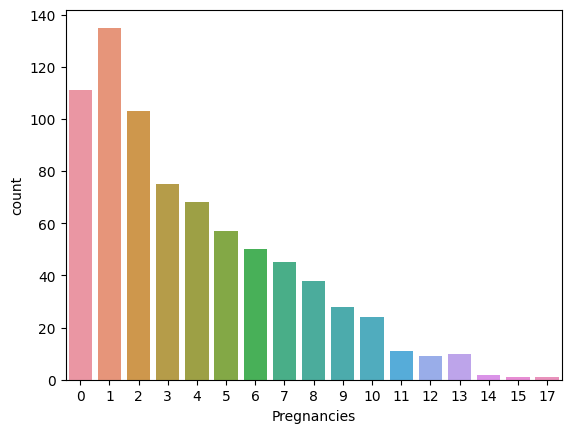

----- Outcome ---------------------------------------------------------------------
        Outcome      
        mean    count
Outcome              
0       0.0000   500 
1       1.0000   268 
----------------------------------------------------------------------------------
         Outcome  Ratio 
Outcome                 
0        500     65.1042
1        268     34.8958
--------------------------------------------------------------------------------------------------------


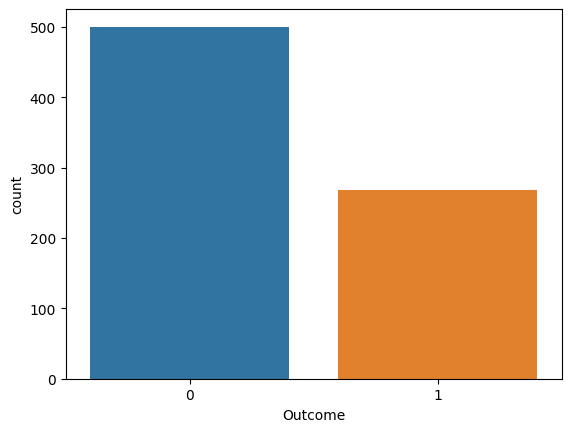

---------------------------------------------
----- Analysis of Numerical Variables -------
---------------------------------------------
----- Glucose ---------------------------------------------------------------------
        Glucose          
        mean     min max 
Outcome                  
0       109.9800  0   197
1       141.2575  0   199
----------------------------------------------------------------------------------
count   768.0000
mean    120.8945
std      31.9726
min       0.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
max     199.0000
Name: Glucose, dtype: float64


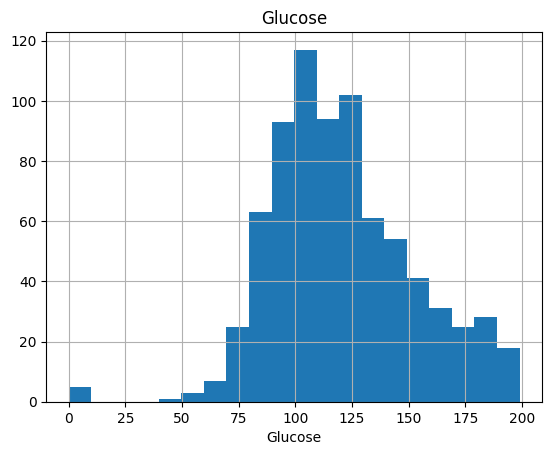

----- BloodPressure ---------------------------------------------------------------------
        BloodPressure         
        mean          min max 
Outcome                       
0       68.1840        0   122
1       70.8246        0   114
----------------------------------------------------------------------------------
count   768.0000
mean     69.1055
std      19.3558
min       0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
max     122.0000
Name: BloodPressure, dtype: float64


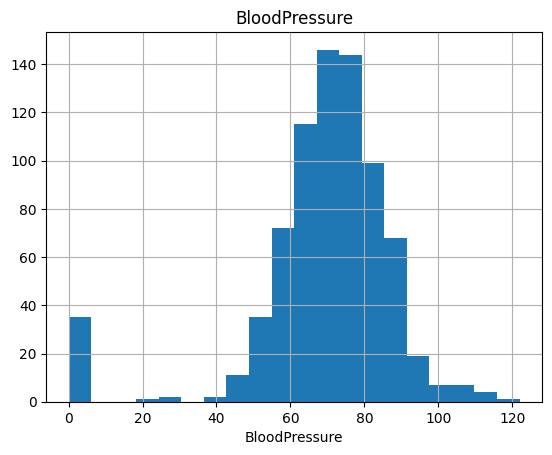

----- SkinThickness ---------------------------------------------------------------------
        SkinThickness        
        mean          min max
Outcome                      
0       19.6640        0   60
1       22.1642        0   99
----------------------------------------------------------------------------------
count   768.0000
mean     20.5365
std      15.9522
min       0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
max      99.0000
Name: SkinThickness, dtype: float64


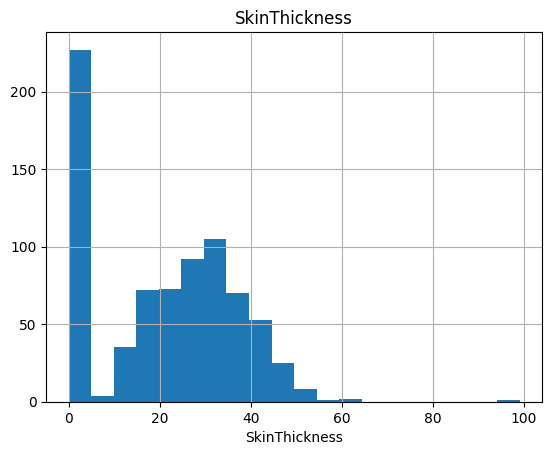

----- Insulin ---------------------------------------------------------------------
        Insulin          
        mean     min max 
Outcome                  
0        68.7920  0   744
1       100.3358  0   846
----------------------------------------------------------------------------------
count   768.0000
mean     79.7995
std     115.2440
min       0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
max     846.0000
Name: Insulin, dtype: float64


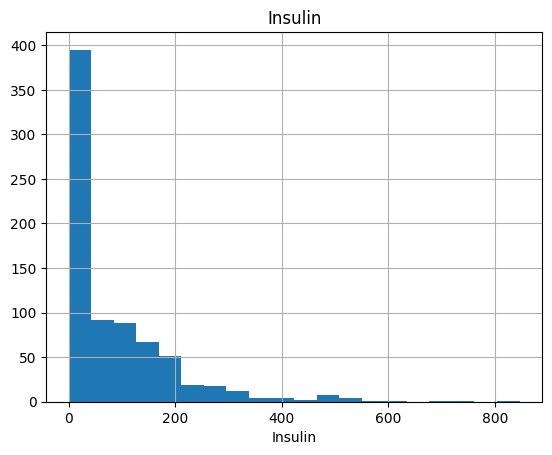

----- BMI ---------------------------------------------------------------------
        BMI                   
        mean    min    max    
Outcome                       
0       30.3042 0.0000 57.3000
1       35.1425 0.0000 67.1000
----------------------------------------------------------------------------------
count   768.0000
mean     31.9926
std       7.8842
min       0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
max      67.1000
Name: BMI, dtype: float64


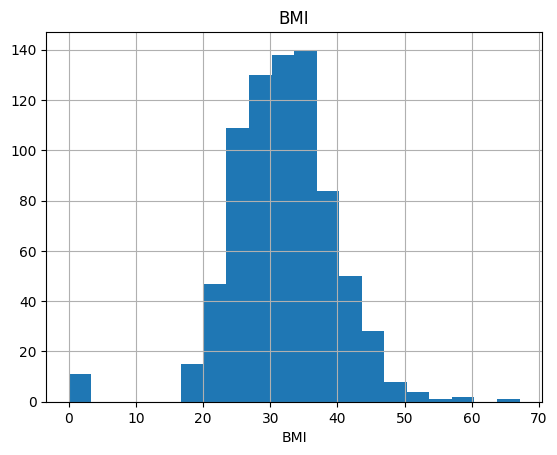

----- DiabetesPedigreeFunction ---------------------------------------------------------------------
        DiabetesPedigreeFunction              
        mean                     min    max   
Outcome                                       
0       0.4297                   0.0780 2.3290
1       0.5505                   0.0880 2.4200
----------------------------------------------------------------------------------
count   768.0000
mean      0.4719
std       0.3313
min       0.0780
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


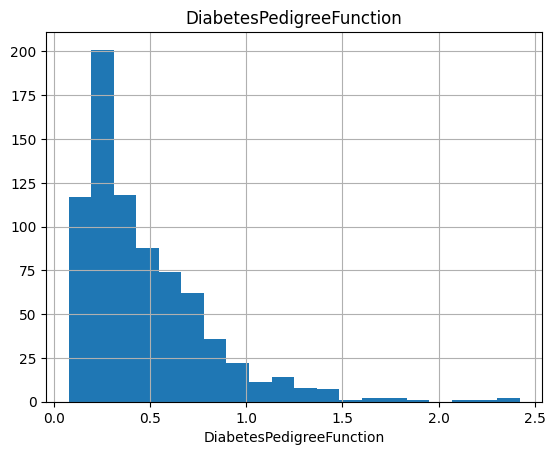

----- Age ---------------------------------------------------------------------
        Age            
        mean    min max
Outcome                
0       31.1900  21  81
1       37.0672  21  70
----------------------------------------------------------------------------------
count   768.0000
mean     33.2409
std      11.7602
min      21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
max      81.0000
Name: Age, dtype: float64


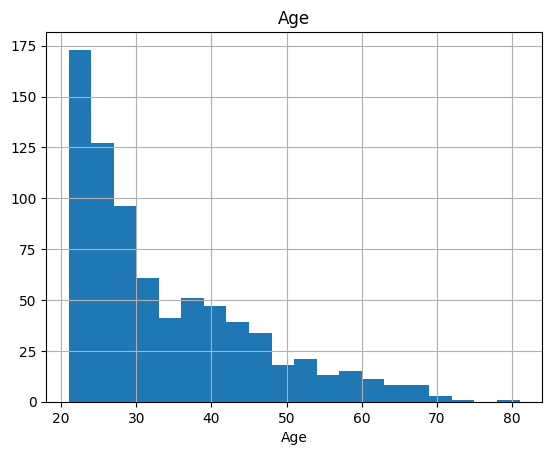

---------------------------------------------
----- Boxplot Analysis ----------------------
---------------------------------------------
----- Glucose ---------------------------------------------------------------------


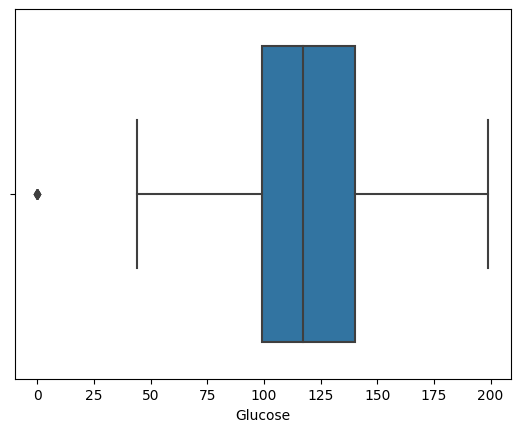

----------------------------------------------------------------------------------
----- BloodPressure ---------------------------------------------------------------------


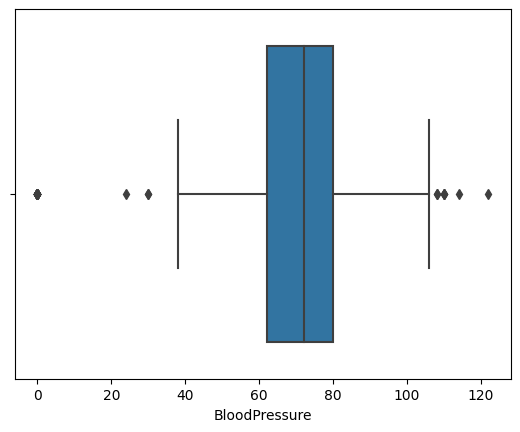

----------------------------------------------------------------------------------
----- SkinThickness ---------------------------------------------------------------------


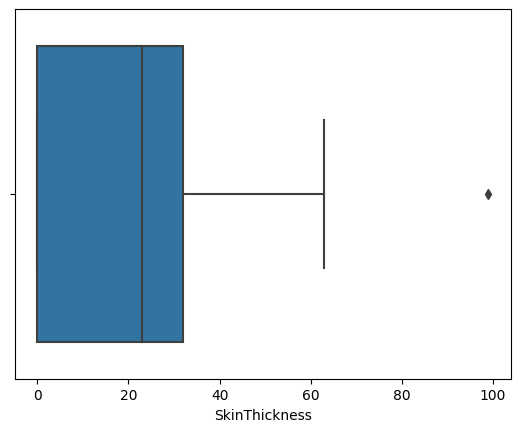

----------------------------------------------------------------------------------
----- Insulin ---------------------------------------------------------------------


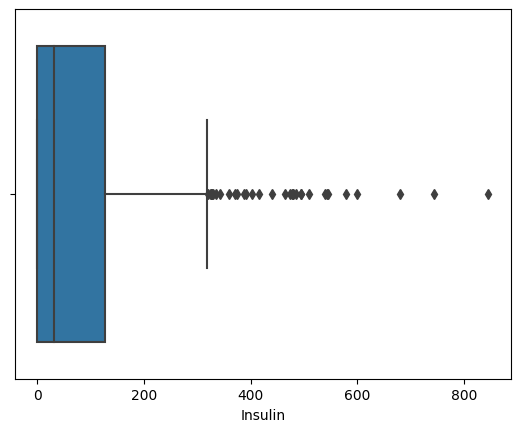

----------------------------------------------------------------------------------
----- BMI ---------------------------------------------------------------------


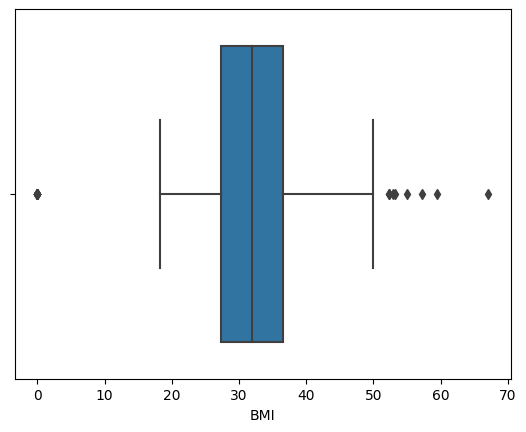

----------------------------------------------------------------------------------
----- DiabetesPedigreeFunction ---------------------------------------------------------------------


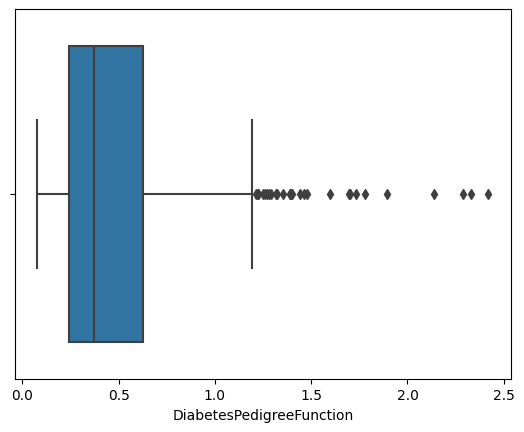

----------------------------------------------------------------------------------
----- Age ---------------------------------------------------------------------


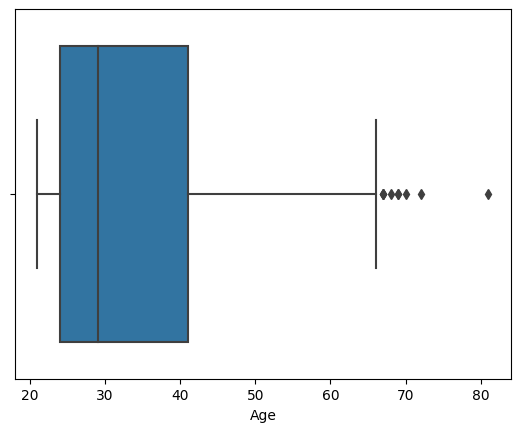

----------------------------------------------------------------------------------


In [8]:
 #- analysis of categorical variables
print("---------------------------------------------")
print("----- Analysis of Categorical Variables -----")
print("---------------------------------------------")
for col in cat_cols:
    print(f"----- {col} ---------------------------------------------------------------------")
    print(df.groupby(col).agg({target_label: ["mean", "count"]}))
    print("----------------------------------------------------------------------------------")
    categoricals_summary(df, col, plot=True)
#---------------------------------------------------------------------------------------------
 #- analysis of numerical variables
print("---------------------------------------------")
print("----- Analysis of Numerical Variables -------")
print("---------------------------------------------")
for col in num_cols:
    print(f"----- {col} ---------------------------------------------------------------------")
    print(df.groupby(target_label).agg({col: ["mean", "min", "max"]}))
    print("----------------------------------------------------------------------------------")
    numericals_summary(df, col, plot=True)
#---------------------------------------------------------------------------------------------
print("---------------------------------------------")
print("----- Boxplot Analysis ----------------------")
print("---------------------------------------------")
 #- box plots
for col in num_cols:
    print(f"----- {col} ---------------------------------------------------------------------")
    sns.boxplot(x=df[col],)
    plt.show(block=True)
    print("----------------------------------------------------------------------------------")

#### Comments:
- There are many variables with outliers.
- Pregnancies: Variable is right skewed. Most of the values are positioned between 0-2. It seems cases above 10 are rare.
- Outcome: In dataset, 1/3 of observations are as 1 and 2/3 of observation as 0 resulted.
- Glucose: It seems that variable almost normally distributed. (except zeroes)
- BloodPressure: It seems that variable is almost normally distributed. (except zeroes and approx. between 20-30)
- SkinThickness: It seems that variable is almost normally distributed. (except zeroes and approx. between 0-10 and above 55)
- Insulin: Variable is right skewed. Most of the values are positioned between 40-200. (except zeroes and approx. above 600)
- BMI: It seems that variable is almost normally distributed (except zeroes and approx. above 50).
- DiabetesPedigreeFunction: Variable is right skewed. Most of the values are positioned between 0.10-0.60. (except approx. above 1.50)
- Age: Variable is right skewed. Most of the values are positioned between 20-50. (except approx. above 60)

## 1.4 - Conduct a target variable analysis. (Mean of the target variable by categorical variables and mean of numerical variables by the target variable)

In [9]:
 #- analysis of categorical variables
for col in cat_cols:
    print(f"{col} ---------------------------------------------------------------------------")
    df_grouped = df.groupby(col).agg({target_label: ["mean", "count"]})
    print(df_grouped.sort_values(by=(target_label, "mean"), ascending=False))
    print("----------------------------------------------------------------------------------")
#---------------------------------------------------------------------------------------------
 #- analysis of numerical variables
for col in num_cols:
    print(f"{col} ---------------------------------------------------------------------------")
    df_grouped = df.groupby(target_label, group_keys=False).agg({col: ["mean", "min", "max"]})
    print(df_grouped.sort_values(by=(col, "mean"), ascending=False))
    print("----------------------------------------------------------------------------------")
#---------------------------------------------------------------------------------------------

Pregnancies ---------------------------------------------------------------------------
            Outcome      
            mean    count
Pregnancies              
17          1.0000     1 
15          1.0000     1 
14          1.0000     2 
9           0.6429    28 
11          0.6364    11 
8           0.5789    38 
7           0.5556    45 
13          0.5000    10 
12          0.4444     9 
10          0.4167    24 
5           0.3684    57 
3           0.3600    75 
0           0.3423   111 
4           0.3382    68 
6           0.3200    50 
1           0.2148   135 
2           0.1845   103 
----------------------------------------------------------------------------------
Outcome ---------------------------------------------------------------------------
        Outcome      
        mean    count
Outcome              
1       1.0000   268 
0       0.0000   500 
----------------------------------------------------------------------------------
Glucose ------------------------

#### Comments:
##### Categorical Variables
- Pregnancies: 
-- Values between 0 and 3 have top frequencies in compare to others.
-- Values between 7 and 13 are distinctive for Outcome with over 40 percent (not considering counts).
-- Values between 14 and 17 are rare.
-- There can be created new features with 4 categories -> (0-3), (4-6), (7-13), (14-17)
- Outcome:     1/3 of observations are as 1 and 2/3 of observation as 0 resulted.

##### Numerical variables
- Glucose:     Glucose may be distinctive with 141.25 for 1 / 109.98 for 0. High glucose may cause positive result.
- Insulin:     Insulin may be distinctive with 100.34 for 1 / 68.79 for 0. High insulin may cause positive result.
- BMI:         BMI may be distinctive with 35.14 for 1 / 30.30 for 0. High BMI may cause positive result.

## 1.5 - Perform outlier analysis.

In [10]:
def outlier_thresholds(dataframe, column_name, q1 = 0.25, q3 = 0.75, print_info=True):
    q1_num = dataframe[column_name].quantile(q1)
    q3_num = dataframe[column_name].quantile(q3)
    iqr = q3_num - q1_num
    lower_threshold = q1_num - iqr * 1.5
    upper_threshold = q3_num + iqr * 1.5
    if print_info:
        print(f"for {column_name}:")
        print(f"Q1 is {q1}")
        print(f"Q3 is {q3}")
        print(f"Q1 threshold is {q1_num}")
        print(f"Q3 threshold is {q3_num}")
        print(f"IQR is {iqr}")
        print(f"Lower threshold is {lower_threshold}")
        print(f"Upper Threshold is {upper_threshold}")
        print("-----------------------------------------------------------------------------------------------------------")
    return lower_threshold, upper_threshold
#----------------------------------------------------------------------------------------------------------------------
def check_if_outlier_exists(dataframe, column_name, q1 = 0.25, q3 = 0.75, print_details=True):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name, q1, q3, print_details)
    if dataframe[((dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit))].shape[0] > 0:
        print(f"{column_name} : Outliers exist based on Q1={q1} and Q3={q3}")
        print(f"Under lower bound: {len(dataframe[dataframe[column_name] < low_limit])} observation of {len(dataframe)}")
        print(f"Above upper bound: {len(dataframe[dataframe[column_name] > up_limit])} observation of {len(dataframe)}")
        print("-------------------------------------------------------------------------------------------------------")
        return True
    else:
        print(f"{column_name} : No Outlier based on Q1={q1} and Q3={q3}")
        print("-------------------------------------------------------------------------------------------------------")
        return False
#----------------------------------------------------------------------------------------------------------------------
def grap_outliers(dataframe, column_name, q1 = 0.25, q3 = 0.75, get_incides=False, print_results=True):

    low_limit, up_limit = outlier_thresholds(dataframe, column_name, q1, q3)

    if print_results:
        if len(dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)]) > 10:
            print(dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)].head())
        else:
            print(dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)])

    if get_incides:
        return dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)].index
#----------------------------------------------------------------------------------------------------------------------
def rare_analyzer(dataframe, target_col_name, forCategoricals=True, forNumericals=False):
    if forCategoricals:
        for col in cat_cols:
            print(f'{col} Count: {len(dataframe[col])}')
            dff = pd.DataFrame({"Count": dataframe[col].value_counts(),
                                "Ratio": dataframe[col].value_counts() / len(dataframe),
                                "Target_Mean": dataframe.groupby(col)[target_col_name].mean()})
            print(dff.sort_values(by=["Ratio", "Target_Mean", "Count"], ascending=[False, False, False]))
            print("-----------------------------------------------------------------------------------")

    if forNumericals:
        for col in num_cols:
            print(f'{col} Count: {len(dataframe[col])}')
            dff = pd.DataFrame({"Count": dataframe[col].value_counts(),
                                "Ratio": dataframe[col].value_counts() / len(dataframe),
                                "Target_Mean": dataframe.groupby(col)[target_col_name].mean()})
            print(dff.sort_values(by=["Ratio", "Target_Mean", "Count"], ascending=[False, False, False]))
            print("-----------------------------------------------------------------------------------")
#----------------------------------------------------------------------------------------------------------------------
def local_outlier_factor_analysis(dataframe, plot=False, return_scores= False, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    lof.fit_predict(dataframe)
    scores_neg = np.sort(lof.negative_outlier_factor_)
    if plot:
        pd.DataFrame(scores_neg).plot(stacked=True, xlim = [0,30], style=".-")
        plt.show()
    if return_scores:
        return scores_neg

---------------------------------------------
----- Boxplot Analysis ----------------------
---------------------------------------------
----- Glucose ---------------------------------------------------------------------


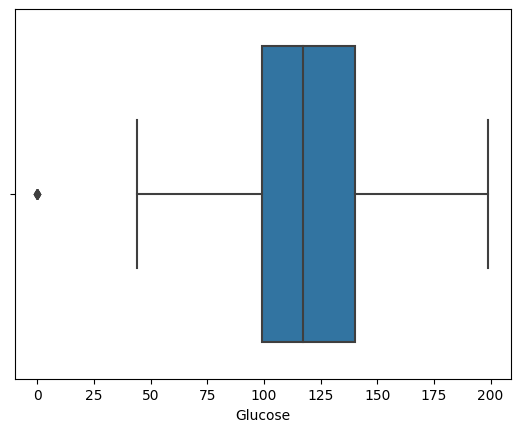

----------------------------------------------------------------------------------
----- BloodPressure ---------------------------------------------------------------------


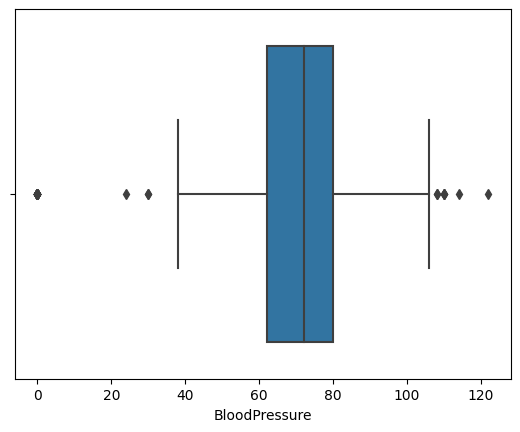

----------------------------------------------------------------------------------
----- SkinThickness ---------------------------------------------------------------------


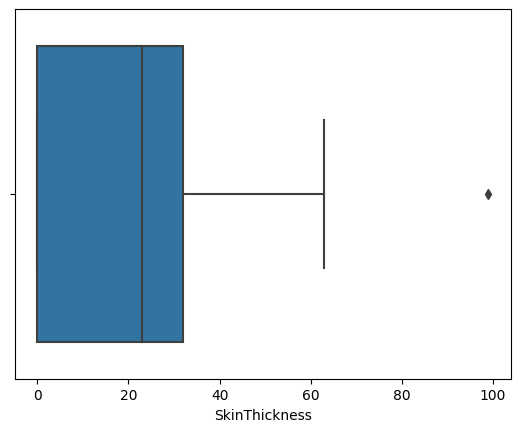

----------------------------------------------------------------------------------
----- Insulin ---------------------------------------------------------------------


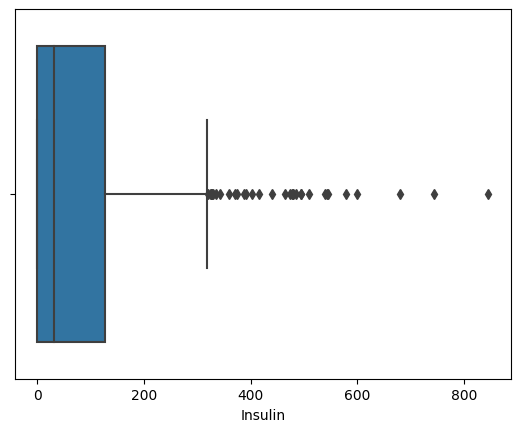

----------------------------------------------------------------------------------
----- BMI ---------------------------------------------------------------------


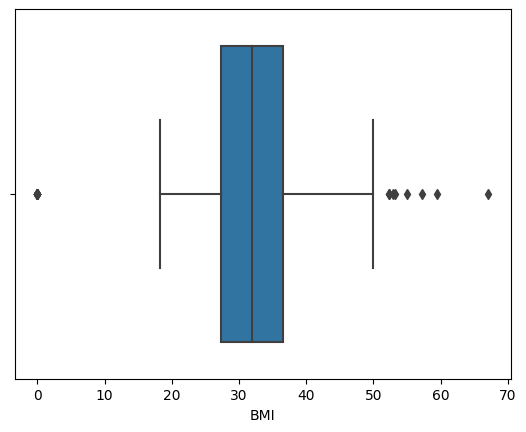

----------------------------------------------------------------------------------
----- DiabetesPedigreeFunction ---------------------------------------------------------------------


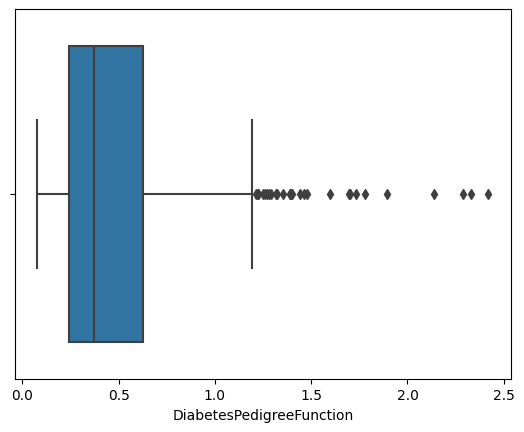

----------------------------------------------------------------------------------
----- Age ---------------------------------------------------------------------


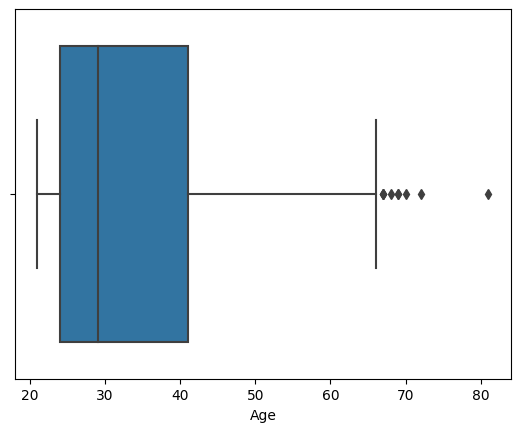

----------------------------------------------------------------------------------
---------------------------------------------
----- Outlier Analysis ----------------------
---------------------------------------------
for Pregnancies:
Q1 is 0.25
Q3 is 0.75
Q1 threshold is 1.0
Q3 threshold is 6.0
IQR is 5.0
Lower threshold is -6.5
Upper Threshold is 13.5
-----------------------------------------------------------------------------------------------------------
Pregnancies : Outliers exist based on Q1=0.25 and Q3=0.75
Under lower bound: 0 observation of 768
Above upper bound: 4 observation of 768
-------------------------------------------------------------------------------------------------------
for Glucose:
Q1 is 0.25
Q3 is 0.75
Q1 threshold is 99.0
Q3 threshold is 140.25
IQR is 41.25
Lower threshold is 37.125
Upper Threshold is 202.125
-----------------------------------------------------------------------------------------------------------
Glucose : Outliers exist based on Q1=0

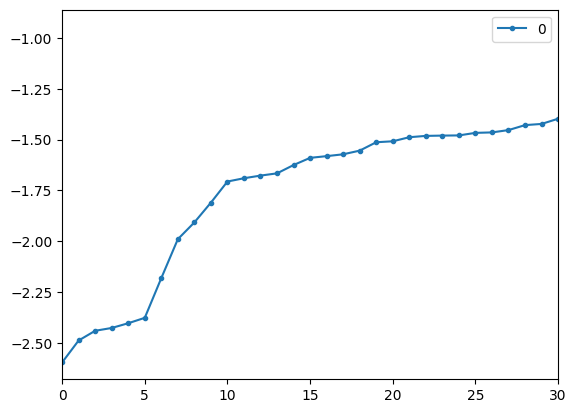

 Based on LOF scores, threshold can be selected as -1.7062264314830031


In [11]:
 #- box plots
print("---------------------------------------------")
print("----- Boxplot Analysis ----------------------")
print("---------------------------------------------")

for col in num_cols:
    print(f"----- {col} ---------------------------------------------------------------------")
    sns.boxplot(x=df[col],)
    plt.show(block=True)
    print("----------------------------------------------------------------------------------")
#---------------------------------------------------------------------------------------------
 #- check if any outlier exists
print("---------------------------------------------")
print("----- Outlier Analysis ----------------------")
print("---------------------------------------------")

for col in df.columns:
    check_if_outlier_exists(df, col, q1=0.25, q3=0.75)
#---------------------------------------------------------------------------------------------

 #- check rarity of values
print("---------------------------------------------")
print("----- Rare Analysis -------------------------")
print("---------------------------------------------")
rare_analyzer(df, target_label, forNumericals=True)
#---------------------------------------------------------------------------------------------
print("---------------------------------------------")
print("----- LOF Analysis --------------------------")
print("---------------------------------------------")
 #- local factor analysis
scores = local_outlier_factor_analysis(df, plot=True, return_scores=True)
print(f" Based on LOF scores, threshold can be selected as {scores[10]}")

#### Comments:
- There are many outliers if thresholds are chosen as 0.25 for Q1 and 0.75 for Q3.
- They should be checked again after correction of 0 values in some features.
- It can be created rare variable for Pregnancies between 14-17
- for LOF, it seems that 10. value can be used as threshold for now (-1.7062264314830031)

## 1.6 - Perform missing data analysis.

In [12]:
def missing_values_summary(dataframe, print_df=True, return_na_col_names=False,return_na_df=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    na_list = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    na_ratios = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    na_df = pd.DataFrame(na_ratios).reset_index().rename(columns={"index": "NA_Column", 0: "Ratio"})
    if print_df:
        if len(na_df) == 0:
            print("There is no missing values in the dataset.")
        else:
            print(na_df)

    if return_na_col_names:
        return na_cols

    if return_na_df:
        return na_df

In [13]:
 #- check for missing values
missing_values_summary(df)
#---------------------------------------------------------------------------------------------

There is no missing values in the dataset.


#### Comments:
- There is no missing values in the dataset but 0 values should be considered as NaN, then all should be checked again.

## 1.7 - Perform correlation analysis.

In [14]:
def correlation_matrix_for_numerical_variables(dataframe, numeric_columns, show_plot=True, return_corr_matrix=False):
    print("-------- Correlation Mapping ---------")
    print("Very Weak Correlation:   (0.00 - 0.19)")
    print("Weak Correlation:        (0.20 - 0.39)")
    print("Moderate Correlation:    (0.40 - 0.59)")
    print("Strong Correlation:      (0.60 - 0.79)")
    print("Very Strong Correlation: (0.80 - 1.00)")
    print("--------------------------------------")
    corr_matrix = dataframe[numeric_columns].corr()
    if show_plot:
        sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="RdBu", annot=True)
        plt.show()
    if return_corr_matrix:
        return corr_matrix

-------- Correlation Mapping ---------
Very Weak Correlation:   (0.00 - 0.19)
Weak Correlation:        (0.20 - 0.39)
Moderate Correlation:    (0.40 - 0.59)
Strong Correlation:      (0.60 - 0.79)
Very Strong Correlation: (0.80 - 1.00)
--------------------------------------


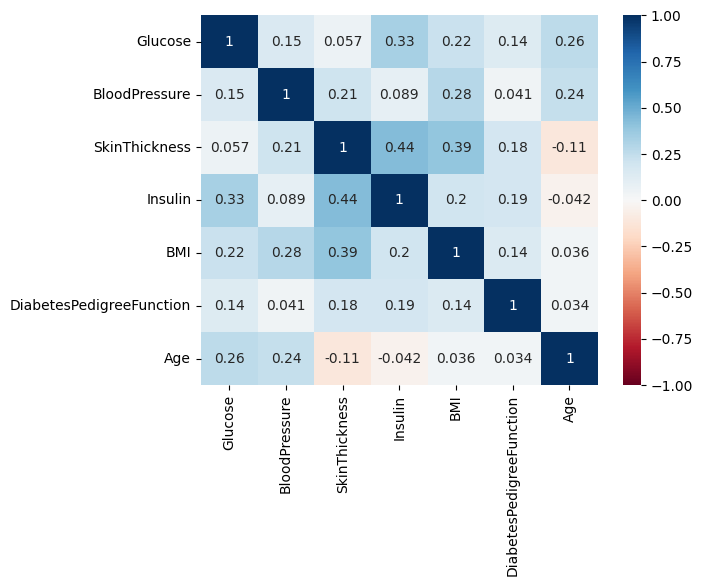

In [15]:
 #- create correlation matrix of numerical variables
correlation_matrix_for_numerical_variables(df, num_cols, show_plot=True)
#---------------------------------------------------------------------------------------------

#### Comments:
- It seems that there is only a moderate positive correlation between "SkinThickess" and "Insulin" with 0.44.

# STEP 2: Feature Engineering
## 2.1 - Perform necessary operations for missing and outlier values. 

_Although there are no missing observations in the dataset, observations containing 0 values in variables like Glucose, Insulin, etc. may represent missing values. For example, a person's Glucose or Insulin value cannot be 0. Considering this, we can assign NaN to zero values in the relevant variables and then apply operations to missing values._

In [16]:
def missing_values_summary(dataframe, print_df=True, return_na_col_names=False,return_na_df=False):
    print("---------------------------------------------")
    print("----- Missing Values Summary ----------------")
    print("---------------------------------------------")
    
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    na_list = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    na_ratios = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    na_df = pd.DataFrame(na_ratios).reset_index().rename(columns={"index": "NA_Column", 0: "Ratio"})
    if print_df:
        if len(na_df) == 0:
            print("There is no missing values in the dataset.")
        else:
            na_df
    
    if return_na_col_names:
        return na_cols

    if return_na_df:
        return na_df
#----------------------------------------------------------------------------------------------------------------------
def missing_values_table(dataframe, na_name=False):
    print("---------------------------------------------")
    print("----- Missing Values Table ------------------")
    print("---------------------------------------------")
    
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df
    if na_name:
        return na_columns
#----------------------------------------------------------------------------------------------------------------------
def missing_vs_target_analysis(dataframe, target_var_name):
    print("---------------------------------------------")
    print("----- Missing Values vs. Target Analysis ----")
    print("---------------------------------------------")
    
    temp_df = dataframe.copy()
    na_columns = missing_values_summary(temp_df, return_na_col_names=True)

    for col in na_columns:
        temp_df[col + "_na_flag"] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_na_flag")].columns

    for col in na_flags:
        print(pd.DataFrame({"Target_Mean": temp_df.groupby(col)[target_var_name].mean(),
                            "Count": temp_df.groupby(col)[target_var_name].count()}))
        print("----------------------------------------------------------------")
#----------------------------------------------------------------------------------------------------------------------
def missing_corr_analysis(dataframe, plot_show=True):
    temp_df = dataframe.copy()
    na_columns = missing_values_summary(temp_df, return_na_col_names=True)
    for col in na_columns:
        temp_df[col + "_na"] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_na")].columns
    corr_missing = temp_df[na_flags].corr()
    #print(corr_missing)
    if plot_show:
        sns.heatmap(corr_missing, cmap="RdBu", annot=True, vmax=1, vmin=-1)
        plt.show(block=True)
#----------------------------------------------------------------------------------------------------------------------
def remove_outliers(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    df_without_outliers = dataframe[~((df[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
#----------------------------------------------------------------------------------------------------------------------
def winsorize_with_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
#----------------------------------------------------------------------------------------------------------------------
def local_outlier_factor_analysis(dataframe, plot=False, return_scores= False, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    lof.fit_predict(dataframe)
    scores_neg = np.sort(lof.negative_outlier_factor_)
    if plot:
        pd.DataFrame(scores_neg).plot(stacked=True, xlim = [0,30], style=".-")
        plt.show()
    if return_scores:
        return scores_neg

#### Copy Dataset

In [17]:
df_w = df.copy()

#### Missing Values

In [18]:
 #- assigning NaN of 0 values of "Glucose, BloodPressure, SkinThickness, Insulin, BMI" are corrected
zero_removing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]
df_w[zero_removing_columns] = df_w[zero_removing_columns].replace(0, np.nan)
df_w

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,NaN,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,NaN,26.6000,0.3510,31,0
2,8,183.0000,64.0000,NaN,NaN,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0000,76.0000,48.0000,180.0000,32.9000,0.1710,63,0
764,2,122.0000,70.0000,27.0000,NaN,36.8000,0.3400,27,0
765,5,121.0000,72.0000,23.0000,112.0000,26.2000,0.2450,30,0
766,1,126.0000,60.0000,NaN,NaN,30.1000,0.3490,47,1


---------------------------------------------
----- Missing Values vs. Target Analysis ----
---------------------------------------------
---------------------------------------------
----- Missing Values Summary ----------------
---------------------------------------------
                 Target_Mean  Count
Glucose_na_flag                    
0               0.3486        763  
1               0.4000          5  
----------------------------------------------------------------
                       Target_Mean  Count
BloodPressure_na_flag                    
0                     0.3438        733  
1                     0.4571         35  
----------------------------------------------------------------
                       Target_Mean  Count
SkinThickness_na_flag                    
0                     0.3327        541  
1                     0.3877        227  
----------------------------------------------------------------
                 Target_Mean  Count
Insulin_na_fl

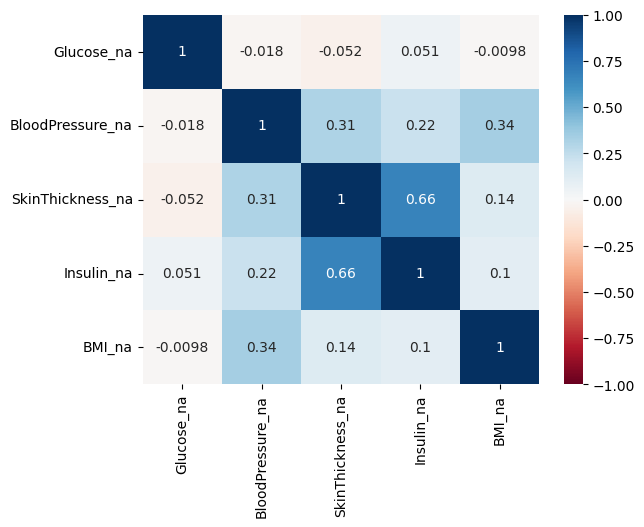

In [19]:
#---------------------------------------------------------------------------------------------
 #- check missing values
missing_vs_target_analysis(df_w, target_label)
print("--------------------------------------------------------------------------------------")
#---------------------------------------------------------------------------------------------
missing_corr_analysis(df_w) #-> Significant correlation between SkinThickness and Insulin

#### Comments:
- It seems that there is a moderate positive correlation between "SkinThickess" and "Insulin" with 0.66 for missing values.

#### Missing Values Solutions

In [20]:
 #- assign means of Pregnancies for each
for col in num_cols:
    df_w[col].fillna(df_w.groupby("Pregnancies")[col].transform("mean"), inplace=True)

df_w

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,167.3158,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,141.7128,26.6000,0.3510,31,0
2,8,183.0000,64.0000,32.9000,251.9286,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0000,76.0000,48.0000,180.0000,32.9000,0.1710,63,0
764,2,122.0000,70.0000,27.0000,138.1562,36.8000,0.3400,27,0
765,5,121.0000,72.0000,23.0000,112.0000,26.2000,0.2450,30,0
766,1,126.0000,60.0000,27.7227,141.7128,30.1000,0.3490,47,1


#### Comments:
- All missing values are filled by their means considering Pregnancy count.

#### Outliers

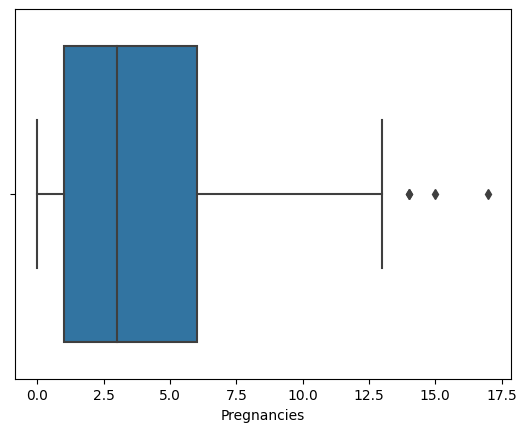

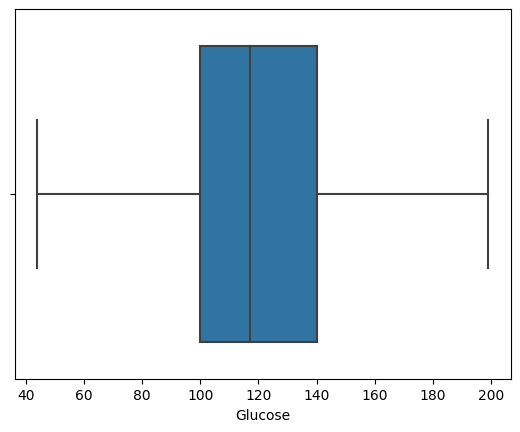

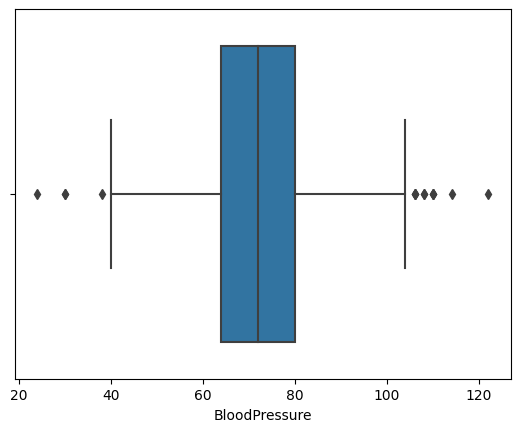

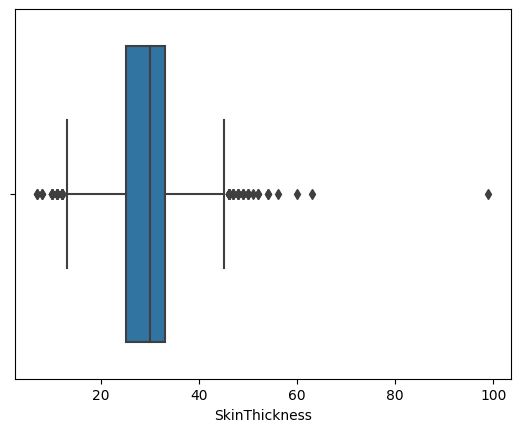

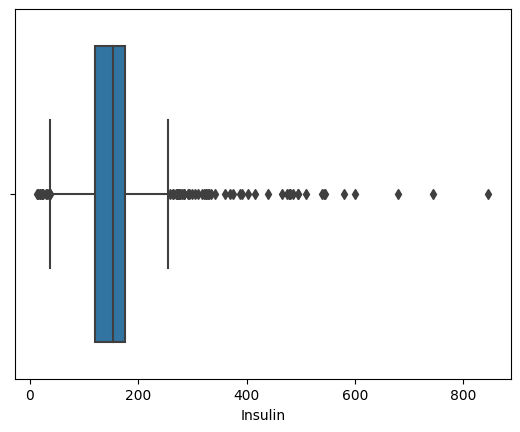

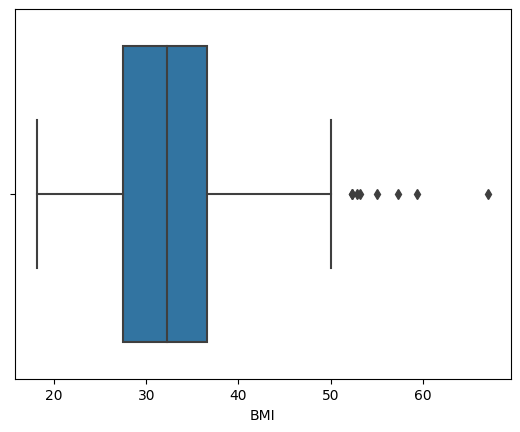

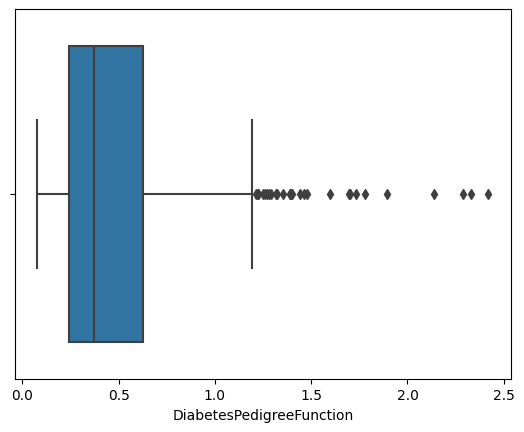

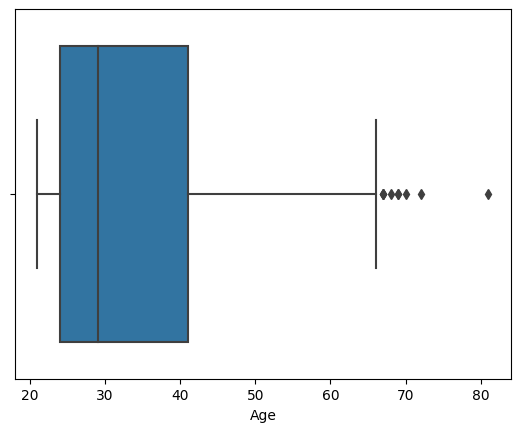

Pregnancies ---------------------------------------------------------------------------
            Outcome      
            mean    count
Pregnancies              
17          1.0000     1 
15          1.0000     1 
14          1.0000     2 
9           0.6429    28 
11          0.6364    11 
8           0.5789    38 
7           0.5556    45 
13          0.5000    10 
12          0.4444     9 
10          0.4167    24 
5           0.3684    57 
3           0.3600    75 
0           0.3423   111 
4           0.3382    68 
6           0.3200    50 
1           0.2148   135 
2           0.1845   103 
----------------------------------------------------------------------------------
Outcome ---------------------------------------------------------------------------
        Outcome      
        mean    count
Outcome              
1       1.0000   268 
0       0.0000   500 
----------------------------------------------------------------------------------
Glucose ------------------------

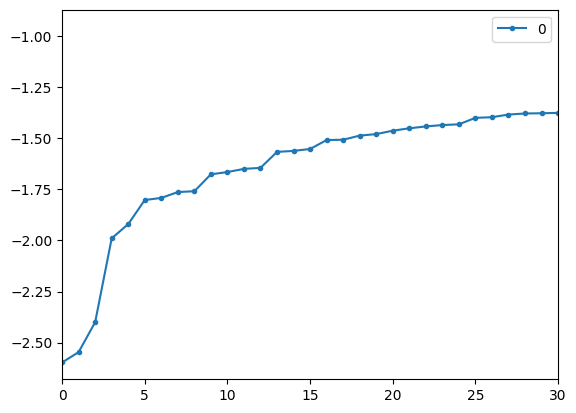

,count,mean,std,min,25%,50%,75%,max
Pregnancies,5.0000,3.2000,3.5637,0.0000,1.0000,1.0000,6.0000,8.0000
Glucose,5.0000,128.4000,41.4584,85.0000,89.0000,137.0000,148.0000,183.0000
BloodPressure,5.0000,61.6000,12.4419,40.0000,64.0000,66.0000,66.0000,72.0000
SkinThickness,5.0000,30.9800,5.0894,23.0000,29.0000,32.9000,35.0000,35.0000
Insulin,5.0000,164.5914,57.3441,94.0000,141.7128,167.3158,168.0000,251.9286
BMI,5.0000,30.9400,7.7494,23.3000,26.6000,28.1000,33.6000,43.1000
DiabetesPedigreeFunction,5.0000,0.8210,0.8457,0.1670,0.3510,0.6270,0.6720,2.2880
Age,5.0000,33.4000,10.4547,21.0000,31.0000,32.0000,33.0000,50.0000
Outcome,5.0000,0.6000,0.5477,0.0000,0.0000,1.0000,1.0000,1.0000


In [21]:
 #- box plots
for col in df_w.columns:
    if col != target_label:
        sns.boxplot(x=df_w[col],)
        plt.show(block=True)
 #- analysis of categorical variables after corrections
for col in cat_cols:
    print(f"{col} ---------------------------------------------------------------------------")
    df_grouped = df.groupby(col).agg({"Outcome": ["mean", "count"]})
    print(df_grouped.sort_values(by=("Outcome", "mean"), ascending=False))
    print("----------------------------------------------------------------------------------")
 #- analysis of numerical variables after corrections
for col in num_cols:
    print(f"{col} ---------------------------------------------------------------------------")
    df_grouped = df.groupby("Outcome", group_keys=False).agg({col: ["mean", "min", "max"]})
    print(df_grouped.sort_values(by=(col, "mean"), ascending=False))
    print("----------------------------------------------------------------------------------")
 #- check if any outlier exists
for col in df.columns:
    check_if_outlier_exists(df, col, q1=0.05, q3=0.95) #--> seem proper as Q1 and Q3
#---------------------------------------------------------------------------------------------
 #- local factor analysis
scores = local_outlier_factor_analysis(df_w, plot=True, return_scores=True) #-> 5. value seems proper (-1.80269)
df_w[scores < scores[5]] #-> only 5 values which can be eliminated (5/768)
df_w[scores < scores[5]].describe().T


#### Outliers Solutions


In [22]:
#---------------------------------------------------------------------------------------------
 #- winsorizing outliers
for col in df.columns:
    winsorize_with_thresholds(df_w, col, q1=0.1, q3=0.9)
#---------------------------------------------------------------------------------------------
 #- eliminating outliers according to LOF
df_w = df_w.drop(index=df_w[scores < scores[5]].index)
print(f"New dataset size: {df_w.shape[0]}")

for Pregnancies:
Q1 is 0.1
Q3 is 0.9
Q1 threshold is 0.0
Q3 threshold is 9.0
IQR is 9.0
Lower threshold is -13.5
Upper Threshold is 22.5
-----------------------------------------------------------------------------------------------------------
for Glucose:
Q1 is 0.1
Q3 is 0.9
Q1 threshold is 86.7
Q3 threshold is 167.0
IQR is 80.3
Lower threshold is -33.749999999999986
Upper Threshold is 287.45
-----------------------------------------------------------------------------------------------------------
for BloodPressure:
Q1 is 0.1
Q3 is 0.9
Q1 threshold is 58.0
Q3 threshold is 88.0
IQR is 30.0
Lower threshold is 13.0
Upper Threshold is 133.0
-----------------------------------------------------------------------------------------------------------
for SkinThickness:
Q1 is 0.1
Q3 is 0.9
Q1 threshold is 18.0
Q3 threshold is 40.0
IQR is 22.0
Lower threshold is -15.0
Upper Threshold is 73.0
------------------------------------------------------------------------------------------------------

#### Comments:
- 0 values of "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction" are corrected as NaN.
- There is a correlation of missing values between SkinThickness and Insulin (0.66).
- Missing values are filled based on Pregnancies group Means. KNN Imputer has not been chosen as Insulin (48%) and SkinThickness (30%) are significantly empty.
- Q1 and Q3 for Outliers are selected as 0.1 and 0.9 as it does not touch that much to many outliers but insulin.
-   Winsorisation has been applied.
- 5 observation of 768 are removed from dataset which are found via LOF.

## 2.2 - Create new variables.

In [23]:
#---------------------------------------------------------------------------------------------
rare_analyzer(df, target_label, forNumericals=True)
#---------------------------------------------------------------------------------------------
df_w["Pregnancies_levels"] = pd.cut(df_w["Pregnancies"], bins=[0,3,6,13,17],labels=["Ordinary","More than Ordinary","Rare","Extraordinary"])
df_w["BMI_levels"] = pd.cut(df_w["BMI"], bins=[0,18.5,24.99999,29.99999,90], labels=["Underweight","Normal Weight","Overweight","Obese"])
df_w["Age_levels"] = pd.cut(df["Age"], bins=[0,10,20,30,40,50,60,70,80,90,100,110,120])
df_w["Glucose_levels"] = pd.cut(df["Glucose"], bins=[0,115,180,280,380,1000], labels=["Excellent","Good","Action Suggested","See Doctor","Dangerous"])
df_w


Pregnancies Count: 768
             Count  Ratio  Target_Mean
Pregnancies                           
1            135   0.1758 0.2148      
0            111   0.1445 0.3423      
2            103   0.1341 0.1845      
3             75   0.0977 0.3600      
4             68   0.0885 0.3382      
5             57   0.0742 0.3684      
6             50   0.0651 0.3200      
7             45   0.0586 0.5556      
8             38   0.0495 0.5789      
9             28   0.0365 0.6429      
10            24   0.0312 0.4167      
11            11   0.0143 0.6364      
13            10   0.0130 0.5000      
12             9   0.0117 0.4444      
14             2   0.0026 1.0000      
15             1   0.0013 1.0000      
17             1   0.0013 1.0000      
-----------------------------------------------------------------------------------
Outcome Count: 768
         Count  Ratio  Target_Mean
Outcome                           
0        500   0.6510 0.0000      
1        268   0.3490 1.0000

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_levels,BMI_levels,Age_levels,Glucose_levels
5,5.0000,116.0000,74.0000,30.9688,155.5238,25.6000,0.2010,30.0000,0.0000,More than Ordinary,Overweight,"(20, 30]",Good
6,3.0000,78.0000,50.0000,32.0000,88.0000,31.0000,0.2480,26.0000,1.0000,Ordinary,Obese,"(20, 30]",Excellent
7,10.0000,115.0000,76.5909,31.4167,139.1667,35.3000,0.1340,29.0000,0.0000,Rare,Obese,"(20, 30]",Excellent
8,2.0000,197.0000,70.0000,45.0000,529.3214,30.5000,0.1580,53.0000,1.0000,Ordinary,Obese,"(50, 60]",Action Suggested
9,8.0000,125.0000,96.0000,32.9000,251.9286,32.4216,0.2320,54.0000,1.0000,Rare,Obese,"(50, 60]",Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0000,101.0000,76.0000,48.0000,180.0000,32.9000,0.1710,63.0000,0.0000,Rare,Obese,"(60, 70]",Excellent
764,2.0000,122.0000,70.0000,27.0000,138.1562,36.8000,0.3400,27.0000,0.0000,Ordinary,Obese,"(20, 30]",Good
765,5.0000,121.0000,72.0000,23.0000,112.0000,26.2000,0.2450,30.0000,0.0000,More than Ordinary,Overweight,"(20, 30]",Good
766,1.0000,126.0000,60.0000,27.7227,141.7128,30.1000,0.3490,47.0000,1.0000,Ordinary,Obese,"(40, 50]",Good


#### Comments:
- from Pregnancies, (0-3), (4-6), (7-13), (14-17) are created.
- from BMI (<0.185)-> Underweight, (0.185-0.249999)-> Normal Weight, (0.25-0.2999999)-> Overweight, (> 30)-> Obese
- from Age (0,10,20,30,40,50,60,70,80,90,100,110,120)
- form Glucose (<150), (150-199),(200-249),(250-299),(300-349), (>=350)

### 2.3 - Perform encoding operations.

In [24]:
def label_encoder_binary(dataframe, return_col_names=True, return_encoded_dataframe=False):
    if return_encoded_dataframe:
        return_col_names = False
    df_ = dataframe.copy()
    binary_columns = []
    label_encoder = LabelEncoder()
    binary_columns = [col for col in df_.columns if df_[col].dtype not in [int, float] and df_[col].nunique() == 2]
    if len(binary_columns) > 0:
        for col in binary_columns:
            df_[col] = label_encoder.fit_transform(df_[col])
    if return_col_names:
        return binary_columns
    if return_encoded_dataframe:
        return df_
#-----------------------------------------------------------------------------------------------------------------------
def one_hot_encoder(dataframe, categorical_columns, drop_first=True, return_dataframe=False, print_df=False):
    df_ = dataframe.copy()
    df_ = pd.get_dummies(df_, columns=categorical_columns, drop_first=drop_first)
    
    if print_df:
        print(df_.head())
    if return_dataframe:
        return df_

In [25]:
#---------------------------------------------------------------------------------------------
 #- use one hot encoder
ohe_cols = ["Pregnancies_levels","BMI_levels","Age_levels","Glucose_levels","Pregnancies"]
df_w = one_hot_encoder(df_w,ohe_cols, return_dataframe=True)
df_w

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_levels_More than Ordinary,Pregnancies_levels_Rare,...,Pregnancies_7.0,Pregnancies_8.0,Pregnancies_9.0,Pregnancies_10.0,Pregnancies_11.0,Pregnancies_12.0,Pregnancies_13.0,Pregnancies_14.0,Pregnancies_15.0,Pregnancies_17.0
5,116.0000,74.0000,30.9688,155.5238,25.6000,0.2010,30.0000,0.0000,True,False,...,False,False,False,False,False,False,False,False,False,False
6,78.0000,50.0000,32.0000,88.0000,31.0000,0.2480,26.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
7,115.0000,76.5909,31.4167,139.1667,35.3000,0.1340,29.0000,0.0000,False,True,...,False,False,False,True,False,False,False,False,False,False
8,197.0000,70.0000,45.0000,529.3214,30.5000,0.1580,53.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
9,125.0000,96.0000,32.9000,251.9286,32.4216,0.2320,54.0000,1.0000,False,True,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,101.0000,76.0000,48.0000,180.0000,32.9000,0.1710,63.0000,0.0000,False,True,...,False,False,False,True,False,False,False,False,False,False
764,122.0000,70.0000,27.0000,138.1562,36.8000,0.3400,27.0000,0.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
765,121.0000,72.0000,23.0000,112.0000,26.2000,0.2450,30.0000,0.0000,True,False,...,False,False,False,False,False,False,False,False,False,False
766,126.0000,60.0000,27.7227,141.7128,30.1000,0.3490,47.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Comments:
- As there is no binary variable except target, one hot encoder has been applied.

## 2.4 - Standardize numerical variables.

In [26]:
#---------------------------------------------------------------------------------------------
standard_cols = [col for col in df_w.columns if col not in ohe_cols]
scaler = StandardScaler()
scaler.fit_transform(df_w[standard_cols])
df_w

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_levels_More than Ordinary,Pregnancies_levels_Rare,...,Pregnancies_7.0,Pregnancies_8.0,Pregnancies_9.0,Pregnancies_10.0,Pregnancies_11.0,Pregnancies_12.0,Pregnancies_13.0,Pregnancies_14.0,Pregnancies_15.0,Pregnancies_17.0
5,116.0000,74.0000,30.9688,155.5238,25.6000,0.2010,30.0000,0.0000,True,False,...,False,False,False,False,False,False,False,False,False,False
6,78.0000,50.0000,32.0000,88.0000,31.0000,0.2480,26.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
7,115.0000,76.5909,31.4167,139.1667,35.3000,0.1340,29.0000,0.0000,False,True,...,False,False,False,True,False,False,False,False,False,False
8,197.0000,70.0000,45.0000,529.3214,30.5000,0.1580,53.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
9,125.0000,96.0000,32.9000,251.9286,32.4216,0.2320,54.0000,1.0000,False,True,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,101.0000,76.0000,48.0000,180.0000,32.9000,0.1710,63.0000,0.0000,False,True,...,False,False,False,True,False,False,False,False,False,False
764,122.0000,70.0000,27.0000,138.1562,36.8000,0.3400,27.0000,0.0000,False,False,...,False,False,False,False,False,False,False,False,False,False
765,121.0000,72.0000,23.0000,112.0000,26.2000,0.2450,30.0000,0.0000,True,False,...,False,False,False,False,False,False,False,False,False,False
766,126.0000,60.0000,27.7227,141.7128,30.1000,0.3490,47.0000,1.0000,False,False,...,False,False,False,False,False,False,False,False,False,False


# STEP 3: Modelling

Now, we test our processed data on two different models.

## 3.1 - K-Nearest Neighbors Model

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

dff = df.copy()
dff.dropna(inplace=True)

X = dff.drop(target_label, axis=1)
y = dff[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

knn = KNeighborsClassifier(n_neighbors=5)
kfold = 10
scores = cross_val_score(knn, X_train, y_train, cv=kfold)

print("----- RAW DATASET RESULTS -----")
#print(f"--> Scores: {scores}")
print("--------------------------------------------------------------------------------------")
print(f"KNN with {kfold}-Fold CV Score: {scores.mean():.4f}")
print("--------------------------------------------------------------------------------------")
print("\n")

#---------------------------------------------------------------------------------------------
X = df_w.drop(target_label, axis=1)
y = df_w[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

knn = KNeighborsClassifier(n_neighbors=5)
kfold = 10
scores = cross_val_score(knn, X_train, y_train, cv=kfold)

print("----- PROCESSED DATASET RESULTS -----")
#print(f"--> Scores: {scores}")
print("--------------------------------------------------------------------------------------")
print(f"KNN with {kfold}-Fold CV Score: {scores.mean():.4f}")
print("--------------------------------------------------------------------------------------")

----- RAW DATASET RESULTS -----
--------------------------------------------------------------------------------------
KNN with 10-Fold CV Score: 0.7001
--------------------------------------------------------------------------------------


----- PROCESSED DATASET RESULTS -----
--------------------------------------------------------------------------------------
KNN with 10-Fold CV Score: 0.7304
--------------------------------------------------------------------------------------


## 3.2 - Random Forest Classifier Model

In [28]:
def feature_importance_levels (model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0: num])
    plt.title('Features') 
    plt.tight_layout()
    plt.show()

----- RAW DATASET RESULTS -----
--------------------------------------------------------------------------------------
Random Forest with 10-Fold CV Score: 0.7532
--------------------------------------------------------------------------------------




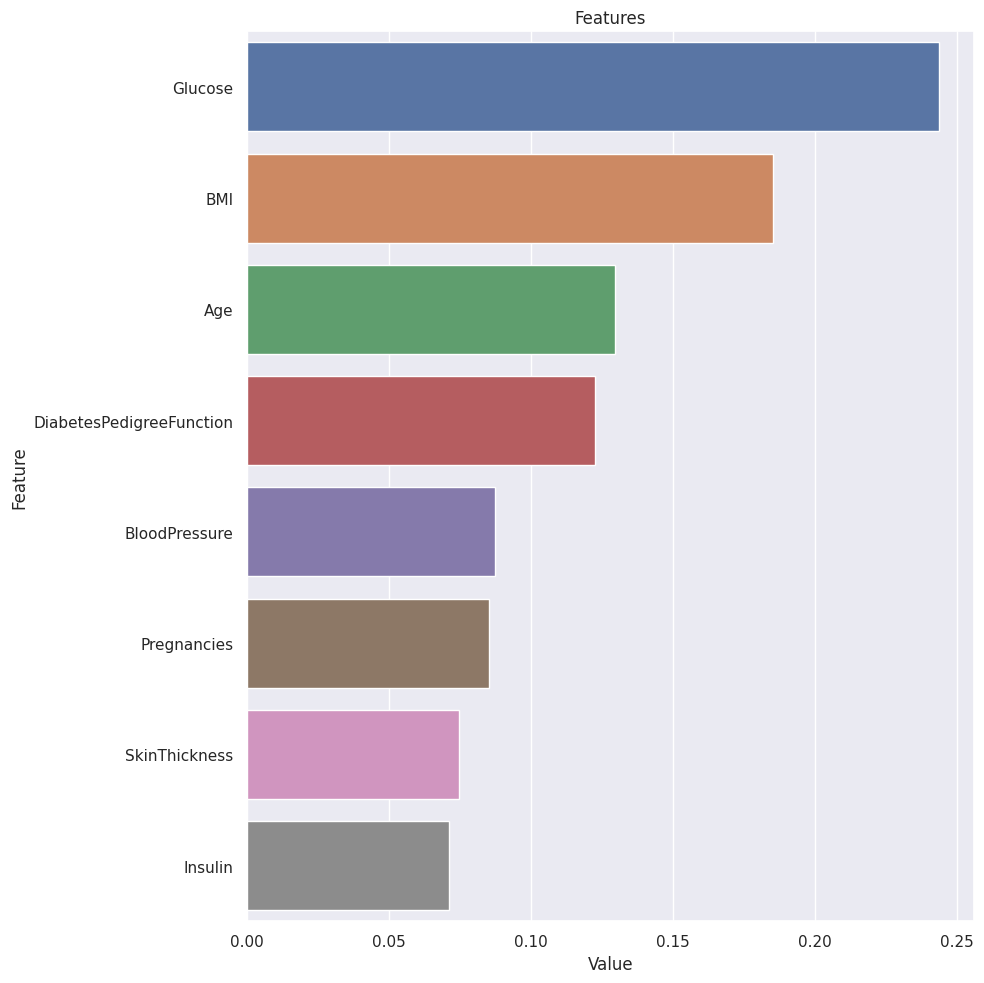

----- PROCESSED DATASET RESULTS -----
--------------------------------------------------------------------------------------
Random Forest with 10-Fold CV Score: 0.7533
--------------------------------------------------------------------------------------


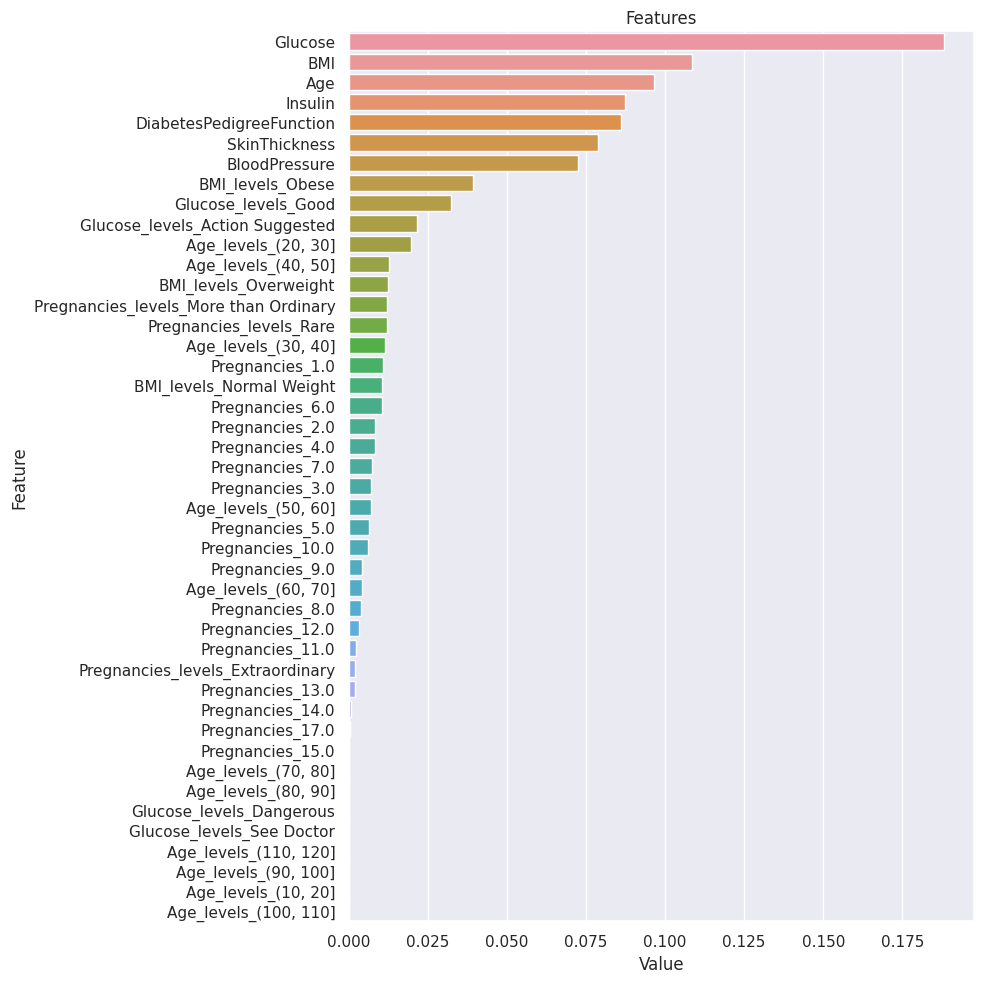

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dff = df.copy()
dff.dropna(inplace=True)

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

scores = []
kfold = 10

for _ in range(kfold):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    rf = RandomForestClassifier().fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores.append(accuracy_score(y_pred, y_test))

print("----- RAW DATASET RESULTS -----")
#print(f"--> Scores: {scores}")
print("--------------------------------------------------------------------------------------")
print(f"Random Forest with {kfold}-Fold CV Score: {np.mean(scores):.4f}")
print("--------------------------------------------------------------------------------------")
print("\n")
feature_importance_levels(rf, X_train)
#---------------------------------------------------------------------------------------------
y = df_w["Outcome"]
X = df_w.drop(["Outcome"], axis=1)

scores = []
kfold = 10

for _ in range(kfold):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    rf = RandomForestClassifier().fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores.append(accuracy_score(y_pred, y_test))

print("----- PROCESSED DATASET RESULTS -----")
#print(f"--> Scores: {scores}")
print("--------------------------------------------------------------------------------------")
print(f"Random Forest with {kfold}-Fold CV Score: {np.mean(scores):.4f}")
print("--------------------------------------------------------------------------------------")
feature_importance_levels(rf, X_train)

More models can be applied. As feature engineering is the main focus of this project, only 2 models is applied for demonstration purposes.

---
### I hope you found the analysis insightful and informative! 
### Your feedback is greatly appreciated, and I welcome any suggestions for improvement. Feel free to reach out with any questions or comments.
---